In [1]:
# Importar as bibliotecas que irão ser utilizadas:

# Para leitura de dados:
import numpy as np
import pandas as pd

# Para criação de gráficos e visualização de informações:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings # To suppress some warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Para montagem do modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(0)

print('Setup completo :)')

Setup completo :)


# 10.1 - Exploração do banco de dados

### 1. O primeiro passo é importar e visualizar o banco de dados, rastrear os valores faltantes e identificar os momentos estatísticos existentes:

In [2]:
# a. Importar o banco de dados utilizando o pandas;
unf_train_data = pd.read_csv('/kaggle/input/szeged-weather/weatherHistory.csv')
unf_train_data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
# b. Identificar o número de valores faltantes em cada colunas;
unf_train_data.isnull().sum()

## i. Qual sua hipótese para a existência desses valores faltantes?
## > Não houve precipitação no dia em questão

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [4]:
# c. Gerar momentos estatísticos do banco de dados;

unf_train_data.describe()

## i. Qual coluna parece fora do comum? Por que?
## > a coluna 'Loud Cover' aparenta não possuir valor algum, totalmente fora do padrão do resto do dataset

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


<ipython-input-5-e0aa702a3f00>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Existem {} valores na coluna Pressure (millibars) que estão errados'.format(unf_train_data.loc[unf_train_data['Pressure (millibars)'].lt(900)].count()[0]))


Existem 1288 valores na coluna Pressure (millibars) que estão errados


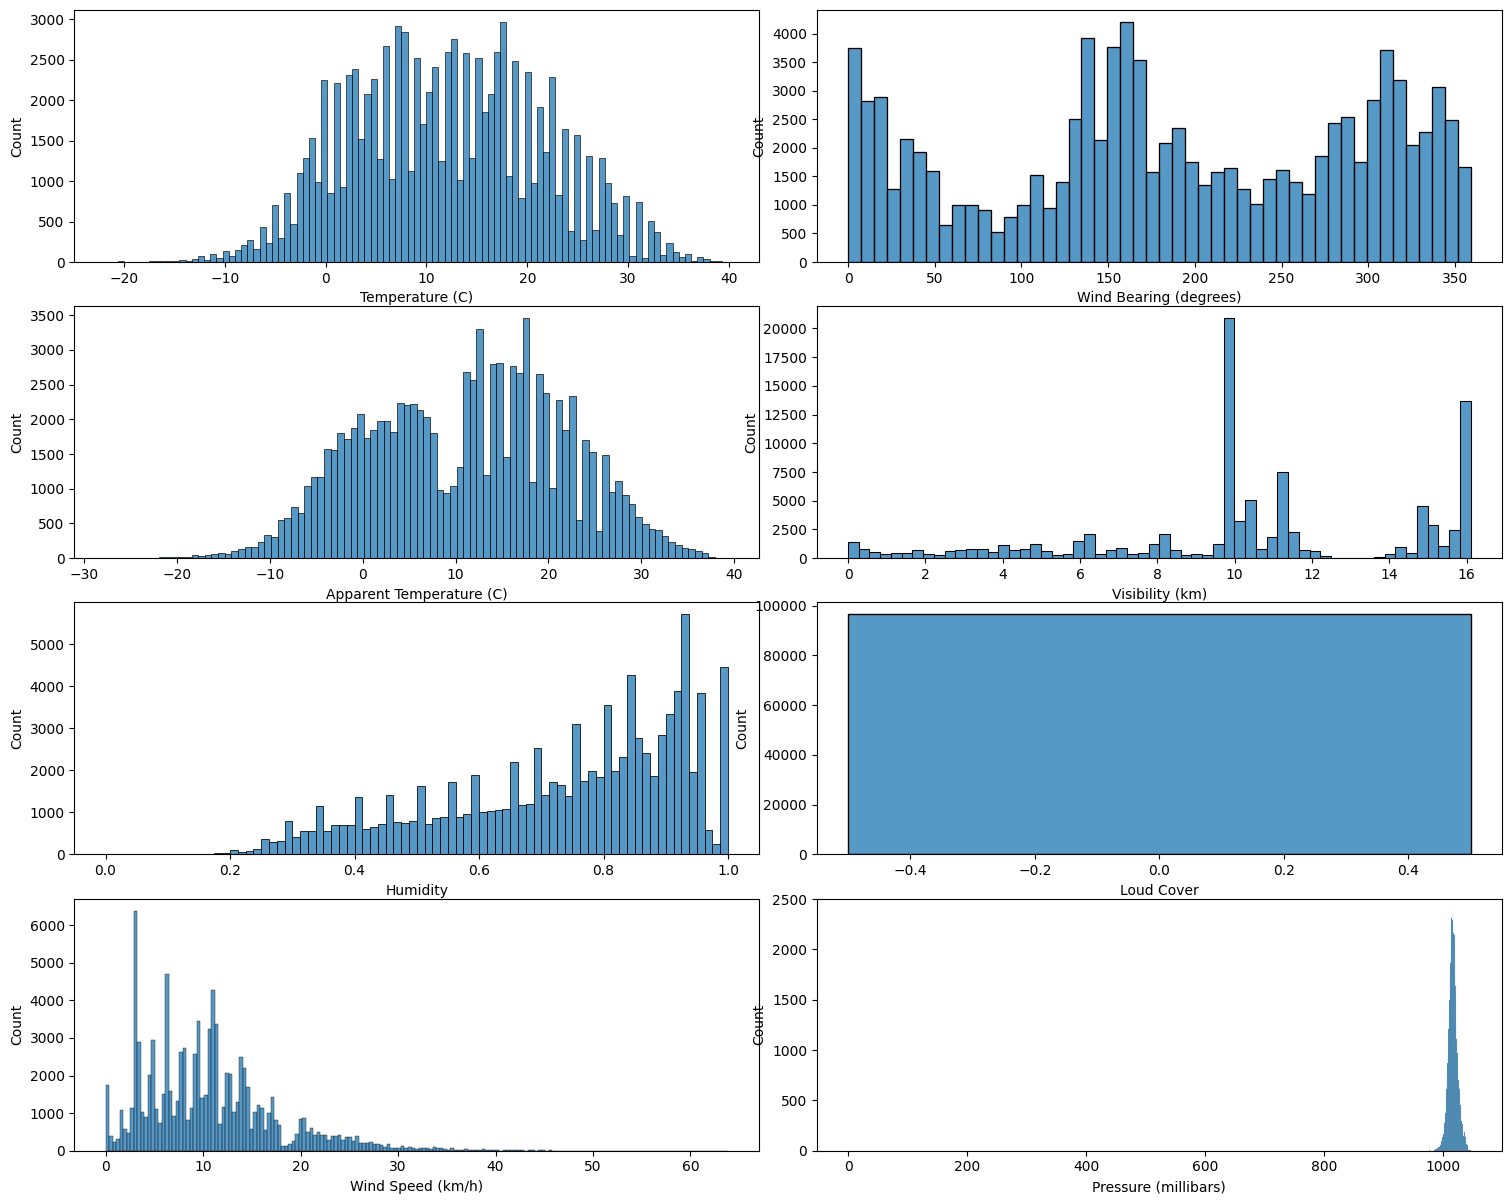

In [5]:
# d. Utilizando o método “.hist” do pandas realize plots de distribuição dos valores das colunas:

fig, ax = plt.subplots(4,2, figsize=(15,12))
fig.tight_layout()

unf_num_cols = unf_train_data.select_dtypes(['int64','float64']).columns

n = 0

for i in [0,1]:
    for j in [0,1,2,3]:
        sns.histplot(unf_train_data[unf_num_cols[n]], ax = ax[j,i])
        n += 1

## i. É possível identificar algo de estranho com a coluna “Pressure(millibars)”. Identifique e explique o que há de errado;
## > Através do gráfico, e também do describe() do dataset, é possível observar alguns dados 'outliers' com valores extremamente baixos

## ii. Utilizando “.loc” do bandas, identifique a quantidade de valores errados.

print('Existem {} valores na coluna Pressure (millibars) que estão errados'.format(unf_train_data.loc[unf_train_data['Pressure (millibars)'].lt(900)].count()[0]))

### 2. Deve-se agora definir quais são as features categóricas e quais são as numéricas, para isso existe o método “.select_dtypes”, aqui será necessário identificar apenas os nomes das features.

In [6]:
# a. Identifique as features numéricas, aquelas que são do tipo “int64” ou “float64”, utilizando “.select_dtypes”;

unf_num_cols = unf_train_data.select_dtypes(['int64','float64']).columns

In [7]:
# b. Identifique as features categóricas, aquelas que são do tipo “object”;

unf_obj_cols = unf_train_data.select_dtypes('object').columns

## i. Uma das features é do tipo object mas não é categórica. Qual é ela?
## > A feature Formatted Date

unf_train_data.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

In [8]:
# c. Inspecione os valores únicos de cada feature categórica, para garantir que não há nenhum valor que ocorra apenas uma vez,
# o que iria interferir na separação do banco de dados em treino e validação (Por que?). Utilize o método ".value_counts" para isso;
# > Influenciaria no fit do modelo, pois o valor único poderia cair no set de validação, impedindo que o modelo seja corretamente
# ajustado (fit).

for i in unf_obj_cols.drop('Formatted Date'):
    print('Valores únicos na feature', i,': \n', unf_train_data[i].value_counts().loc[unf_train_data[i].value_counts().lt(2)], '\n')

## i. Há uma feature em que existem valores que não ocorrem mais de uma vez. esse valores serão retirados do banco de dados futuramente;

Valores únicos na feature Summary : 
 Summary
Windy and Dry                          1
Dangerously Windy and Partly Cloudy    1
Breezy and Dry                         1
Name: count, dtype: int64 

Valores únicos na feature Precip Type : 
 Series([], Name: count, dtype: int64) 

Valores únicos na feature Daily Summary : 
 Series([], Name: count, dtype: int64) 



# 10.2 - Limpeza do banco de dados

### 1. Uma das features do tipo “object” é “Formatted Date” que, na verdade, indica a data do registro climático. Essa coluna deverá então ser transformada para o formato de data para que seja possível extrair informações úteis para o treinamento do modelo.

In [9]:
# a. Existe um valor nessa feature que indica o fuso-horário (“+0200”). Para que a coluna seja corretamente transformada este valor desse ser retirado;

## i. Deve ser realizado um processo semelhante ao item 9.2-1, em que será utilizado o método “str.split” para retirar o texto “+0200” de todos
## os valores da feature;

unf_train_data['Formatted Date'] = unf_train_data['Formatted Date'].str.split('+', n=1, expand=True)[0]

## ii. Use o método "to_datetime" para transformar a coluna no formato desejado.

unf_train_data['Formatted Date'] = pd.to_datetime(unf_train_data['Formatted Date'])

unf_train_data.dtypes

Formatted Date              datetime64[ns]
Summary                             object
Precip Type                         object
Temperature (C)                    float64
Apparent Temperature (C)           float64
Humidity                           float64
Wind Speed (km/h)                  float64
Wind Bearing (degrees)             float64
Visibility (km)                    float64
Loud Cover                         float64
Pressure (millibars)               float64
Daily Summary                       object
dtype: object

In [10]:
# b. Utilizando os métodos existentes em “.dt” crie novas colunas retirando as informações de hora, dia, mês e ano de cada valor de data na feature;

## i. Utilize os métodos “dt.hour ”, “dt.day ”, “dt.month ”, “dt.year ”;

unf_train_data['Hour'] = unf_train_data['Formatted Date'].dt.hour
unf_train_data['Day'] = unf_train_data['Formatted Date'].dt.day
unf_train_data['Month'] = unf_train_data['Formatted Date'].dt.month
unf_train_data['Year'] = unf_train_data['Formatted Date'].dt.year

## ii. Retire a coluna original de data do banco de dados.

unf_train_data.drop('Formatted Date', axis=1, inplace = True)

### 2. Agora será criada a pipeline para completar a limpeza dos dados, com ela será realizada a substituição dos valores faltantes nas colunas “Pressure (millibars)” e “Precip Type” e o encoding, utilizando ordinal encoder, das variáveis categóricas. Para isso será utilizada a biblioteca Column Transformer do sklearn, mas antes deverão ser retirados os dados que não servirão para o treinamento do modelo.

In [11]:
# a. Retirar a coluna “Loud Cover”, já que contém apenas valores nulos, e linhas cujo valor da coluna “Summary” aparecem apenas uma vez;

train_topip = unf_train_data.copy()

## i. Para localizar as linhas que serão retiradas utilize o método “.loc”.

train_topip.drop('Loud Cover', axis=1, inplace=True)
train_topip.drop(train_topip.loc[(train_topip['Summary'] == 'Windy and Dry') | (train_topip['Summary'] == 'Dangerously Windy and Partly Cloudy') | (train_topip['Summary'] == 'Breezy and Dry')].index, inplace=True)

train_topip.dtypes

Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Pressure (millibars)        float64
Daily Summary                object
Hour                          int32
Day                           int32
Month                         int32
Year                          int32
dtype: object

In [12]:
# b. Definir imputers para variáveis numéricas e para categóricas, e o encoder das variáveis categóricas;

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

topip_num_cols = train_topip.select_dtypes(['int64','float64','int32']).columns
topip_cat_cols = train_topip.select_dtypes('object').columns

## i. Configurar imputer das variáveis numéricas com simple imputer, utilizando a média como substituta do valor faltante e indicando que o
## valor 0 significa valor faltante (valores iguais a 0 em “Pressure (millibars)” representam valores faltantes);

num_imputer = SimpleImputer(strategy='mean', missing_values = 0)

## ii. Criar uma pipeline para tratamento das variáveis categóricas, primeiro passo deve ser a substituição dos valores faltantes utilizando simple
## imputer, substituindo o valor faltante por um texto, o segundo passo é realizar o encoding utilizando ordinal encoder.

OEnc = OrdinalEncoder()

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),('encoder', OEnc)])

In [13]:
# c. Criar um objeto do tipo Column Transformer para aplicar os passos criados anteriormente.

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([('num', num_imputer, list(topip_num_cols)),('cat', cat_transformer, list(topip_cat_cols.drop('Daily Summary')))], remainder='passthrough')

### 3. O último passo da limpeza dos dados será a separação em treino e validação, aplicação da pipeline de limpeza e o encoding da coluna que será o target (“Daily summary”).

In [14]:
# a. Definir quais são as features, o que é o target e separar o banco de dados utilizando train-test split,
# deve-se garantir que todos os valores do target estão distribuídos de forma equilibrada na reparação do banco de dados;

## i. Indicar o target como sendo “Daily Summary” e as features como as colunas restantes;

X = train_topip.copy()
y = X.pop('Daily Summary')

## ii. Utilizar train-test split, configurado para que o tamanho do banco de dados de teste seja 30% do banco de dados original e utilizando o
## target como parâmetro de “stratify”;

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.3, stratify = y)

train_X

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Hour,Day,Month,Year
21859,Partly Cloudy,rain,27.244444,26.744444,0.34,10.9641,172.0,9.9820,1011.93,19,6,7,2008
29271,Foggy,snow,-5.000000,-5.000000,0.84,4.8300,40.0,2.5760,1040.40,15,11,1,2009
44494,Mostly Cloudy,rain,13.200000,13.200000,0.69,10.8353,289.0,14.9086,1023.80,22,6,4,2011
48498,Mostly Cloudy,rain,25.861111,25.861111,0.60,5.9087,4.0,11.2700,1016.77,18,2,6,2011
89893,Overcast,rain,9.888889,8.405556,0.93,10.6743,301.0,6.3112,1021.51,16,1,2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18772,Mostly Cloudy,rain,18.655556,18.655556,0.76,10.4650,250.0,15.8263,1014.87,4,29,8,2008
76619,Mostly Cloudy,rain,15.044444,15.044444,0.44,13.7494,351.0,10.2557,1017.73,15,5,5,2014
17431,Overcast,rain,8.866667,5.888889,0.89,20.7207,311.0,4.0089,1010.10,7,5,9,2007
58605,Overcast,rain,10.555556,10.555556,0.89,0.0000,0.0,12.0750,1013.40,22,14,5,2012


In [15]:
# b. Aplicar pipeline de limpeza do banco de dados;

## i. Utilize apenas as features dentro da pipeline, ajuste utilizando as features de treino e apenas transforme as de teste.

cltrain_X = preprocessor.fit_transform(train_X)
clval_X = preprocessor.transform(val_X)

data_final = pd.DataFrame(cltrain_X, columns = list(topip_num_cols) + list(topip_cat_cols.drop('Daily Summary')))

data_final

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Hour,Day,Month,Year,Summary,Precip Type
0,27.244444,26.744444,0.34,10.964100,172.000000,9.9820,1011.93,19.0,6.0,7.0,2008.0,17.0,1.0
1,-5.000000,-5.000000,0.84,4.830000,40.000000,2.5760,1040.40,15.0,11.0,1.0,2009.0,10.0,2.0
2,13.200000,13.200000,0.69,10.835300,289.000000,14.9086,1023.80,22.0,6.0,4.0,2011.0,15.0,1.0
3,25.861111,25.861111,0.60,5.908700,4.000000,11.2700,1016.77,18.0,2.0,6.0,2011.0,15.0,1.0
4,9.888889,8.405556,0.93,10.674300,301.000000,6.3112,1021.51,16.0,1.0,2.0,2016.0,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67510,18.655556,18.655556,0.76,10.465000,250.000000,15.8263,1014.87,4.0,29.0,8.0,2008.0,15.0,1.0
67511,15.044444,15.044444,0.44,13.749400,351.000000,10.2557,1017.73,15.0,5.0,5.0,2014.0,15.0,1.0
67512,8.866667,5.888889,0.89,20.720700,311.000000,4.0089,1010.10,7.0,5.0,9.0,2007.0,16.0,1.0
67513,10.555556,10.555556,0.89,10.948206,192.037999,12.0750,1013.40,22.0,14.0,5.0,2012.0,16.0,1.0


In [16]:
# c. Utilize label encoder para realizar o encoding do target.

from sklearn.preprocessing import LabelEncoder
LEnc = LabelEncoder()

## i. Da mesma forma, utilize o target de treino para ajustar e apenas transforme o de teste.

enctrain_y = LEnc.fit_transform(train_y)
encval_y = LEnc.transform(val_y)

# 10.3 - Treinamento e Avaliação da rede neural

### 1. Primeiramente deve-se criar a arquitetura da rede neural, ela terá duas camadas escondidas, sendo cada uma com uma saída de dimensão 256, entre elas serão utilizados Batch normalization e Dropout. Como funções de ativação serão usados “relu” para as camadas escondidas e o “softmax” na camada de saída, esta função serve para que o modelo realize predições na forma de classificação não binária, ou seja, que seja capaz de prever mais de duas classes.

In [17]:
# a. Configurar o tamanho da entrada, que é o número de features para treinamento, e o tamanho da saída, que será a quantidade de classes do
# target;

from tensorflow import keras
from tensorflow.keras import layers

input_shape = X.shape[1]
print('Tamanho da entrada: ', input_shape)

output_shape = y.nunique()
print('Tamanho da saída: ', output_shape)

Tamanho da entrada:  13
Tamanho da saída:  214


In [18]:
# b. Construir arquitetura do modelo utilizando a descrição já informada;

model = keras.Sequential([
    
    ## i. Camada de entrada utilizando batch normalization configurando seu tamanho a partir das features do banco de dados;

    layers.BatchNormalization(),

    ## ii. Primeira camada escondida utilizando “relu” como função de ativação, saída de dimensão 256, batch normalization e dropout de 0.3;

    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),

    ## iii. Segunda camada escondida igual à primeira;

    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),

    ## iv. Camada de saída com tamanho igual ao número de classes do target e função de ativação “softmax”.

    layers.Dense(output_shape, activation='softmax'),

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# c. Realizar tratamento do target utilizando o método “utils.to_categorical” do keras.

## i. Transformar target de treino e de teste utilizando o método do keras;

ktrain_y = keras.utils.to_categorical(enctrain_y)
kval_y = keras.utils.to_categorical(encval_y)

## ii. Veja as dimensões da matriz de target e responda, o target é composto de quantas classes (Possíveis previsões)?

ktrain_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 2. Configurar o otimizador, a função de perda que será utilizada e a métrica para avaliação do modelo.

In [20]:
# a. Como otimizador será utilizado “adam”, como função de perda “categorical_crossentropy” e como métrica para avaliação
# “categorical_accuracy”.

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

### 3. Por fim, será realizado o treinamento do modelo e plotagem dos resultados das avaliações, será utilizado o early stopping para evitar o overfitting. Os hiperparâmetros que serão utilizados, como o número de épocas e tamanho de cada batch durante o treinamento do modelo podem ser alterados pelo aluno para teste e possível aprimoramento.

In [21]:
# a. Configurar early stopping;

## i. Utilizar a biblioteca do keras para configurar early stopping, com uma tolerância de 10 épocas e uma variação mínima no resultado da função
## de perda de 0.001.

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

cltrain_X

array([[ 2.72444444e+01,  2.67444444e+01,  3.40000000e-01, ...,
         2.00800000e+03,  1.70000000e+01,  1.00000000e+00],
       [-5.00000000e+00, -5.00000000e+00,  8.40000000e-01, ...,
         2.00900000e+03,  1.00000000e+01,  2.00000000e+00],
       [ 1.32000000e+01,  1.32000000e+01,  6.90000000e-01, ...,
         2.01100000e+03,  1.50000000e+01,  1.00000000e+00],
       ...,
       [ 8.86666667e+00,  5.88888889e+00,  8.90000000e-01, ...,
         2.00700000e+03,  1.60000000e+01,  1.00000000e+00],
       [ 1.05555556e+01,  1.05555556e+01,  8.90000000e-01, ...,
         2.01200000e+03,  1.60000000e+01,  1.00000000e+00],
       [ 2.35444444e+01,  2.35444444e+01,  6.00000000e-01, ...,
         2.00700000e+03,  1.70000000e+01,  1.00000000e+00]])

In [22]:
# b. Realizar o treino e armazenar os resultados da avaliação do modelo;

history = model.fit(

    ## i. Utilizar as features e target de treino para treinar o modelo;
    cltrain_X, ktrain_y,

    ## ii. Utilizar os dados de teste para validar o modelo;
    validation_data=(clval_X, kval_y),

    ## iii. Utilizar um tamanho de batch de 3000;
    batch_size=3000,

    ### iv. Utilizar 100 épocas para treino;
    epochs=100,

    ### v. Indicar utilização de early stopping;
    callbacks=[early_stopping],

    verbose=0, # esconde o texto das épocas
)

Best Validation Loss: 1.5253
Best Validation Accuracy: 0.5145


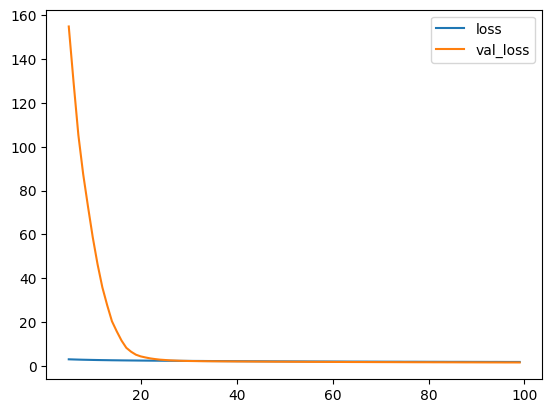

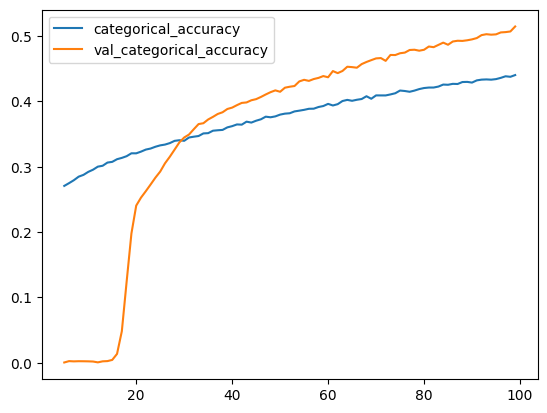

In [23]:
# c. Para a plotagem deve-se transformar os resultados do treino em um dataframe o pandas e plotar os valores de perda e acurácia em função das épocas.

## i. Utilizar o método “.DataFrame” para transformar resultados em data frame do pandas;

history_df = pd.DataFrame(history.history)

## ii. Utilizar gráfico de linha para plotar os resultados da perda e da acurácia em função das épocas de treino.

history_df.head()

history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))